In [25]:
from __future__ import division
from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
#import plotly.offline as pyoff
import plotly as py
import plotly.graph_objs as go
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
#pyoff.init_notebook_mode()
#from plotly.offline import init_notebook_mode, iplot
py.offline.init_notebook_mode(connected=True) 
import seaborn as sns

In [97]:
%time sales = pd.read_csv("data/Water_System_14-19.csv")

Wall time: 2.18 s


In [98]:
sales=sales.sort_values(by=['Date'])

In [99]:
sales.head(10) 

,Date,OrderNumber,OrderLineNumber,Quantity,SellPrice,CCN,PartnerNumber,Material,ItemCategoryGroup,ItemCategory,...,Region,SubRegion,Industry,IndustryGroup,Plant,PlantType,PlantPlatform,Market,MonthYear,Column 32
29526,01/02/2014,order_number_111590,130,3,29.33326,ccn_59201,partner_number_1153,mat_2998,item_cat_grp_6,item_cat_13,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Moosic,Unassigned,plant_platform_2,Water Resources,01/2014,NaN
32568,01/02/2014,order_number_111590,300,1,111.99972,ccn_17874,partner_number_40010,mat_5233,item_cat_grp_6,item_cat_13,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN
32569,01/02/2014,order_number_111590,310,3,918.66437,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN
32570,01/02/2014,order_number_111590,310,2,35.99991,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN
32571,01/02/2014,order_number_111590,310,1,729.33151,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN
32572,01/02/2014,order_number_111590,310,2,45.33322,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN
32573,01/02/2014,order_number_111590,310,8,39.99990,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN
32574,01/02/2014,order_number_111590,310,8,206.66615,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN
32575,01/02/2014,order_number_111590,310,1,11.99997,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN
32576,01/02/2014,order_number_111590,310,1,171.99957,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,West,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN


In [21]:
print (sales.dtypes)

Date                    object
OrderNumber             object
OrderLineNumber          int64
Quantity                 int64
SellPrice              float64
CCN                     object
PartnerNumber           object
Material                object
ItemCategoryGroup       object
ItemCategory            object
ItemDescription         object
ProductCode             object
ProductDescription      object
NounCodeDescription     object
NounCode                object
ShipFrom                object
CustomerName            object
CustId                  object
City                    object
State                   object
PostalCode              object
Country                 object
Region                  object
SubRegion               object
Industry                object
IndustryGroup           object
Plant                   object
PlantType               object
PlantPlatform           object
Market                  object
MonthYear               object
Column 32              float64
dtype: o

In [164]:
#calculate the revenue for each row, and adding month year feature

#converting the type of Invoice Date Field from string to datetime.
sales['Date'] = pd.to_datetime(sales['Date'])
#creating YearMonth field for the ease of reporting and visualization
sales['InvoiceYearMonth'] = sales['Date'].map(lambda date: 100*date.year + date.month)

#calculate Revenue for each row and create a new dataframe with YearMonth - Revenue columns
sales['Revenue'] = sales['SellPrice'] * sales['Quantity']
tx_revenue = sales.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
tx_revenue

,InvoiceYearMonth,Revenue
0,201401,2.751596e+06
1,201402,2.201021e+06
2,201403,3.150713e+06
3,201404,4.530337e+06
4,201405,3.159471e+06
5,201406,2.779041e+06
6,201407,1.615616e+06
7,201408,2.105360e+06
8,201409,4.103072e+06
9,201410,5.372469e+06


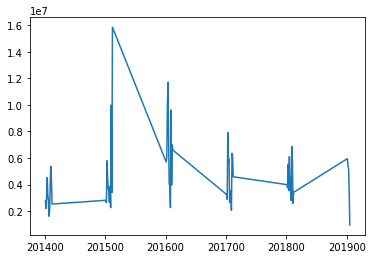

In [56]:
plt.plot(tx_revenue['InvoiceYearMonth'], tx_revenue['Revenue'])
plt.show()

In [57]:
sales.head(10)

,Date,OrderNumber,OrderLineNumber,Quantity,SellPrice,CCN,PartnerNumber,Material,ItemCategoryGroup,ItemCategory,...,Market,MonthYear,Column 32,InvoiceYearMonth,Revenue,MinPurchaseDate_x,MinPurchaseYearMonth_x,UserType,MinPurchaseDate_y,MinPurchaseYearMonth_y
0,2014-01-02,order_number_111590,130,3,29.33326,ccn_59201,partner_number_1153,mat_2998,item_cat_grp_6,item_cat_13,...,Water Resources,01/2014,NaN,201401,87.99978,2014-01-02,201401,New,2014-01-02,201401
1,2014-01-02,order_number_111590,300,1,111.99972,ccn_17874,partner_number_40010,mat_5233,item_cat_grp_6,item_cat_13,...,Water Resources,01/2014,NaN,201401,111.99972,2014-01-02,201401,New,2014-01-02,201401
2,2014-01-02,order_number_111590,310,3,918.66437,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,2755.99311,2014-01-02,201401,New,2014-01-02,201401
3,2014-01-02,order_number_111590,310,2,35.99991,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,71.99982,2014-01-02,201401,New,2014-01-02,201401
4,2014-01-02,order_number_111590,310,1,729.33151,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,729.33151,2014-01-02,201401,New,2014-01-02,201401
5,2014-01-02,order_number_111590,310,2,45.33322,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,90.66644,2014-01-02,201401,New,2014-01-02,201401
6,2014-01-02,order_number_111590,310,8,39.99990,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,319.99920,2014-01-02,201401,New,2014-01-02,201401
7,2014-01-02,order_number_111590,310,8,206.66615,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,1653.32920,2014-01-02,201401,New,2014-01-02,201401
8,2014-01-02,order_number_111590,310,1,11.99997,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,11.99997,2014-01-02,201401,New,2014-01-02,201401
9,2014-01-02,order_number_111590,310,1,171.99957,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,171.99957,2014-01-02,201401,New,2014-01-02,201401


In [11]:
#X and Y axis inputs for Plotly graph. We use Scatter for line graphs
# plot_data = [
#     go.Scatter(
#         x=tx_revenue['InvoiceYearMonth'],
#         y=tx_revenue['Revenue'],
#     )
# ]

# plot_layout = go.Layout(
#         xaxis={"type": "category"},
#         title='Montly Revenue'
#     )
# fig = go.Figure(data=plot_data, layout=plot_layout)
# py.offline.iplot(fig)

In [61]:
#Calculate monthly change in percantage (pct_change)

tx_revenue['MonthlyGrowth'] = tx_revenue['Revenue'].pct_change()*100
tx_revenue['MonthlyGrowth'].head(20)

0            NaN
1     -20.009284
2      43.147804
3      43.787645
4     -30.259692
5     -12.040932
6     -41.864264
7      30.313151
8      94.886968
9      30.937714
10    -20.509202
11    -40.742286
12     11.242155
13     -5.887605
14    118.713788
15    -23.478356
16    -14.627337
17    -11.536977
18    -20.854920
19     46.018271
Name: MonthlyGrowth, dtype: float64

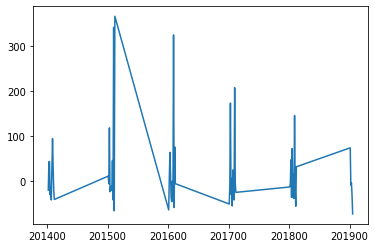

In [60]:
plt.plot(tx_revenue['InvoiceYearMonth'], tx_revenue['MonthlyGrowth'])
plt.show()

In [15]:
sales.head(10)

,Date,OrderNumber,OrderLineNumber,Quantity,SellPrice,CCN,PartnerNumber,Material,ItemCategoryGroup,ItemCategory,...,Industry,IndustryGroup,Plant,PlantType,PlantPlatform,Market,MonthYear,Column 32,InvoiceYearMonth,Revenue
29526,2014-01-02,order_number_111590,130,3,29.33326,ccn_59201,partner_number_1153,mat_2998,item_cat_grp_6,item_cat_13,...,WATER SYSTEMS EXTR & TRMNT,WATER,Moosic,Unassigned,plant_platform_2,Water Resources,01/2014,NaN,201401,87.99978
32568,2014-01-02,order_number_111590,300,1,111.99972,ccn_17874,partner_number_40010,mat_5233,item_cat_grp_6,item_cat_13,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,111.99972
32569,2014-01-02,order_number_111590,310,3,918.66437,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,2755.99311
32570,2014-01-02,order_number_111590,310,2,35.99991,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,71.99982
32571,2014-01-02,order_number_111590,310,1,729.33151,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,729.33151
32572,2014-01-02,order_number_111590,310,2,45.33322,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,90.66644
32573,2014-01-02,order_number_111590,310,8,39.99990,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,319.99920
32574,2014-01-02,order_number_111590,310,8,206.66615,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,1653.32920
32575,2014-01-02,order_number_111590,310,1,11.99997,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,11.99997
32576,2014-01-02,order_number_111590,310,1,171.99957,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,WATER SYSTEMS EXTR & TRMNT,WATER,Chesapeake,Unassigned,plant_platform_1,Water Resources,01/2014,NaN,201401,171.99957


In [22]:
# count customers ID's for each month
tx_monthly_active = sales.groupby('InvoiceYearMonth')['CustId'].nunique().reset_index()
tx_monthly_active.head(10)

,InvoiceYearMonth,CustId
0,201401,20
1,201402,24
2,201403,20
3,201404,27
4,201405,20
5,201406,24
6,201407,20
7,201408,19
8,201409,23
9,201410,26


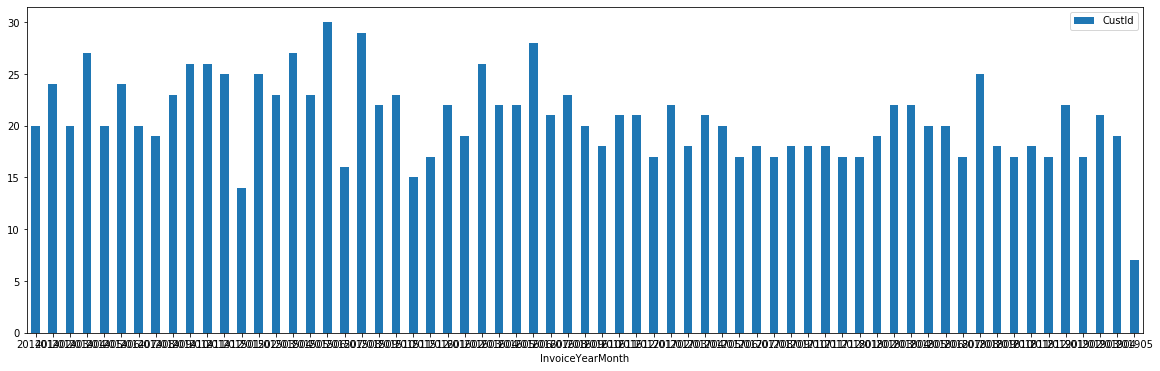

In [29]:
ax = tx_monthly_active.plot.bar(x='InvoiceYearMonth', y='CustId', rot=0, figsize=(20, 6))

In [63]:
# number of orders for each month
tx_monthly_active = sales.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()
tx_monthly_active.head(10)

,InvoiceYearMonth,Quantity
0,201401,9620
1,201402,8255
2,201403,9606
3,201404,9095
4,201405,8875
5,201406,6284
6,201407,4285
7,201408,5450
8,201409,11934
9,201410,7485


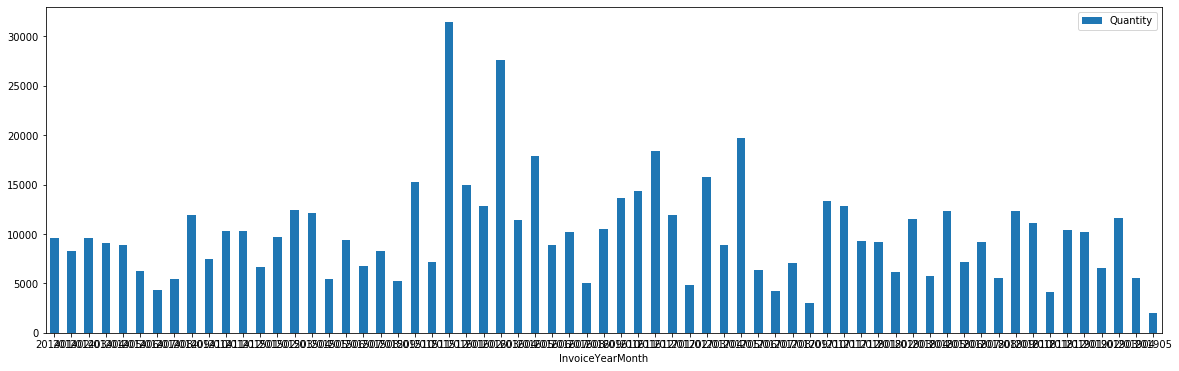

In [64]:
ax = tx_monthly_active.plot.bar(x='InvoiceYearMonth', y='Quantity', rot=0, figsize=(20, 6))

In [65]:
sales.head(20)

,Date,OrderNumber,OrderLineNumber,Quantity,SellPrice,CCN,PartnerNumber,Material,ItemCategoryGroup,ItemCategory,...,Market,MonthYear,Column 32,InvoiceYearMonth,Revenue,MinPurchaseDate_x,MinPurchaseYearMonth_x,UserType,MinPurchaseDate_y,MinPurchaseYearMonth_y
0,2014-01-02,order_number_111590,130,3,29.33326,ccn_59201,partner_number_1153,mat_2998,item_cat_grp_6,item_cat_13,...,Water Resources,01/2014,NaN,201401,87.99978,2014-01-02,201401,New,2014-01-02,201401
1,2014-01-02,order_number_111590,300,1,111.99972,ccn_17874,partner_number_40010,mat_5233,item_cat_grp_6,item_cat_13,...,Water Resources,01/2014,NaN,201401,111.99972,2014-01-02,201401,New,2014-01-02,201401
2,2014-01-02,order_number_111590,310,3,918.66437,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,2755.99311,2014-01-02,201401,New,2014-01-02,201401
3,2014-01-02,order_number_111590,310,2,35.99991,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,71.99982,2014-01-02,201401,New,2014-01-02,201401
4,2014-01-02,order_number_111590,310,1,729.33151,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,729.33151,2014-01-02,201401,New,2014-01-02,201401
5,2014-01-02,order_number_111590,310,2,45.33322,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,90.66644,2014-01-02,201401,New,2014-01-02,201401
6,2014-01-02,order_number_111590,310,8,39.99990,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,319.99920,2014-01-02,201401,New,2014-01-02,201401
7,2014-01-02,order_number_111590,310,8,206.66615,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,1653.32920,2014-01-02,201401,New,2014-01-02,201401
8,2014-01-02,order_number_111590,310,1,11.99997,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,11.99997,2014-01-02,201401,New,2014-01-02,201401
9,2014-01-02,order_number_111590,310,1,171.99957,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,Water Resources,01/2014,NaN,201401,171.99957,2014-01-02,201401,New,2014-01-02,201401


In [33]:
# average revenue for each month 

tx_monthly_active = sales.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()
tx_monthly_active.head(10)

,InvoiceYearMonth,Revenue
0,201401,605.411614
1,201402,483.847255
2,201403,701.717919
3,201404,797.594485
4,201405,688.487855
5,201406,857.464070
6,201407,654.360454
7,201408,839.792609
8,201409,1008.869537
9,201410,1509.544601


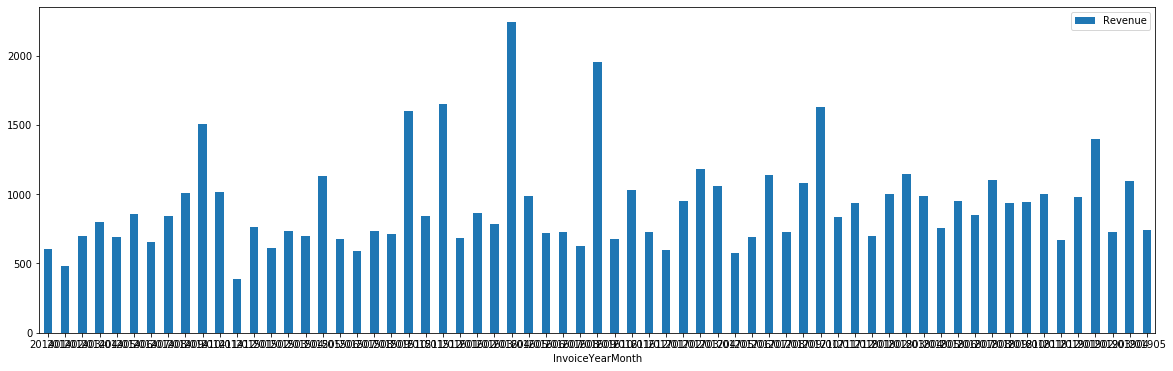

In [35]:
ax = tx_monthly_active.plot.bar(x='InvoiceYearMonth', y='Revenue', rot=0, figsize=(20, 6))

In [66]:
#create a dataframe contaning CustomerID and first purchase date

tx_min_purchase = sales.groupby('CustId').Date.min().reset_index()
tx_min_purchase.columns = ['CustId','MinPurchaseDate']
tx_min_purchase['MinPurchaseYearMonth'] = tx_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)
tx_min_purchase

,CustId,MinPurchaseDate,MinPurchaseYearMonth
0,cust_id_1037,2015-05-26,201505
1,cust_id_1044,2014-01-28,201401
2,cust_id_1072,2018-11-29,201811
3,cust_id_1110,2015-04-17,201504
4,cust_id_1140,2015-02-09,201502
5,cust_id_1198,2014-11-17,201411
6,cust_id_121,2014-03-20,201403
7,cust_id_1211,2014-02-06,201402
8,cust_id_124,2014-06-17,201406
9,cust_id_1260,2016-08-25,201608


In [67]:
#merge first purchase date column to our main dataframe
sales = pd.merge(sales, tx_min_purchase, on='CustId')
sales.head(20)

,Date,OrderNumber,OrderLineNumber,Quantity,SellPrice,CCN,PartnerNumber,Material,ItemCategoryGroup,ItemCategory,...,Column 32,InvoiceYearMonth,Revenue,MinPurchaseDate_x,MinPurchaseYearMonth_x,UserType,MinPurchaseDate_y,MinPurchaseYearMonth_y,MinPurchaseDate,MinPurchaseYearMonth
0,2014-01-02,order_number_111590,130,3,29.33326,ccn_59201,partner_number_1153,mat_2998,item_cat_grp_6,item_cat_13,...,NaN,201401,87.99978,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
1,2014-01-02,order_number_111590,300,1,111.99972,ccn_17874,partner_number_40010,mat_5233,item_cat_grp_6,item_cat_13,...,NaN,201401,111.99972,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
2,2014-01-02,order_number_111590,310,3,918.66437,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,2755.99311,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
3,2014-01-02,order_number_111590,310,2,35.99991,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,71.99982,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
4,2014-01-02,order_number_111590,310,1,729.33151,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,729.33151,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
5,2014-01-02,order_number_111590,310,2,45.33322,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,90.66644,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
6,2014-01-02,order_number_111590,310,8,39.99990,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,319.99920,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
7,2014-01-02,order_number_111590,310,8,206.66615,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,1653.32920,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
8,2014-01-02,order_number_111590,310,1,11.99997,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,11.99997,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
9,2014-01-02,order_number_111590,310,1,171.99957,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,171.99957,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401


In [68]:
#create a column called User Type and assign Existing 
#if User's First Purchase Year Month before the selected Invoice Year Month
sales['UserType'] = 'New'
sales.loc[sales['InvoiceYearMonth']>sales['MinPurchaseYearMonth'],'UserType'] = 'Existing'
sales.head()

,Date,OrderNumber,OrderLineNumber,Quantity,SellPrice,CCN,PartnerNumber,Material,ItemCategoryGroup,ItemCategory,...,Column 32,InvoiceYearMonth,Revenue,MinPurchaseDate_x,MinPurchaseYearMonth_x,UserType,MinPurchaseDate_y,MinPurchaseYearMonth_y,MinPurchaseDate,MinPurchaseYearMonth
0,2014-01-02,order_number_111590,130,3,29.33326,ccn_59201,partner_number_1153,mat_2998,item_cat_grp_6,item_cat_13,...,NaN,201401,87.99978,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
1,2014-01-02,order_number_111590,300,1,111.99972,ccn_17874,partner_number_40010,mat_5233,item_cat_grp_6,item_cat_13,...,NaN,201401,111.99972,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
2,2014-01-02,order_number_111590,310,3,918.66437,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,2755.99311,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
3,2014-01-02,order_number_111590,310,2,35.99991,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,71.99982,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401
4,2014-01-02,order_number_111590,310,1,729.33151,ccn_35441,partner_number_14416,mat_2491,item_cat_grp_1,item_cat_15,...,NaN,201401,729.33151,2014-01-02,201401,New,2014-01-02,201401,2014-01-02,201401


In [47]:
#calculate the Revenue per month for each user type
tx_user_type_revenue = sales.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()
tx_user_type_revenue.head(20)

,InvoiceYearMonth,UserType,Revenue
0,201401,New,2.751596e+06
1,201402,Existing,1.976800e+06
2,201402,New,2.242208e+05
3,201403,Existing,2.946885e+06
4,201403,New,2.038288e+05
5,201404,Existing,3.174095e+06
6,201404,New,1.356242e+06
7,201405,Existing,3.157887e+06
8,201405,New,1.583996e+03
9,201406,Existing,2.718479e+06


In [51]:
#filtering the dates and plot the result, just to show the data
tx_user_type_revenue1 = tx_user_type_revenue.query("InvoiceYearMonth > 201512")
tx_user_type_revenue1

,InvoiceYearMonth,UserType,Revenue
44,201601,Existing,5.683203e+06
45,201601,New,1.627729e+04
46,201602,Existing,6.036873e+06
47,201602,New,4.628388e+04
48,201603,Existing,9.923094e+06
49,201603,New,6.048118e+04
50,201604,Existing,1.156308e+07
51,201604,New,1.233917e+05
52,201605,Existing,7.278516e+06
53,201605,New,1.200917e+05


In [52]:
#create a dataframe that shows new user ratio - we also need to drop NA values (first month new user ratio is 0)
tx_user_ratio = sales.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustId'].nunique()/sales.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustId'].nunique() 
tx_user_ratio = tx_user_ratio.reset_index()
tx_user_ratio = tx_user_ratio.dropna()
#<1 - existing more
#print the dafaframe
tx_user_ratio

,InvoiceYearMonth,CustId
1,201402,0.600000
2,201403,0.538462
3,201404,0.588235
4,201405,0.052632
5,201406,0.200000
6,201407,0.250000
7,201408,0.117647
8,201409,0.095238
9,201410,0.238095
10,201411,0.181818


In [71]:
#identify which users are active by looking at their revenue per month
tx_user_purchase = sales.groupby(['CustId','InvoiceYearMonth'])['Revenue'].sum().reset_index()
tx_user_purchase


,CustId,InvoiceYearMonth,Revenue
0,cust_id_1037,201505,807.99798
1,cust_id_1044,201401,5269.32016
2,cust_id_1044,201604,31050.58904
3,cust_id_1044,201606,55279.86180
4,cust_id_1044,201705,191.99952
5,cust_id_1044,201710,46619.88345
6,cust_id_1044,201802,11285.30512
7,cust_id_1072,201811,98.66642
8,cust_id_1110,201504,677.33164
9,cust_id_1110,201506,919.99770


In [73]:
#create retention matrix with crosstab
tx_retention = pd.crosstab(tx_user_purchase['CustId'], tx_user_purchase['InvoiceYearMonth']).reset_index()

tx_retention.head(100)

InvoiceYearMonth,CustId,201401,201402,201403,201404,201405,201406,201407,201408,201409,...,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905
0,cust_id_1037,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,cust_id_1044,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,cust_id_1072,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,cust_id_1110,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,cust_id_1140,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,cust_id_1198,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,cust_id_121,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,cust_id_1211,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,cust_id_124,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,cust_id_1260,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
#create an array of dictionary which keeps Retained & Total User count for each month
#customer bought in 2 consequencs months

months = tx_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
#convert the array to dataframe and calculate Retention Rate
tx_retention = pd.DataFrame(retention_array)
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount']/tx_retention['TotalUserCount']
tx_retention

,InvoiceYearMonth,TotalUserCount,RetainedUserCount,RetentionRate
0,201403,20,13,0.650000
1,201404,27,11,0.407407
2,201405,20,16,0.800000
3,201406,24,15,0.625000
4,201407,20,13,0.650000
5,201408,19,12,0.631579
6,201409,23,14,0.608696
7,201410,26,14,0.538462
8,201411,26,15,0.576923
9,201412,25,15,0.600000


In [93]:
#create our retention table again with crosstab() - we need to change the column names for using them in .query() function

tx_retention = pd.crosstab(tx_user_purchase['CustId'], tx_user_purchase['InvoiceYearMonth']).reset_index()
new_column_names = [ 'm_' + str(column) for column in tx_retention.columns]
tx_retention.columns = new_column_names

#create the array of Retained users for each cohort monthly
retention_array = []
for i in range(len(months)):
    retention_data = {}
    selected_month = months[i]
    prev_months = months[:i]
    next_months = months[i+1:]
    for prev_month in prev_months:
        retention_data[prev_month] = np.nan
        
    total_user_count =  retention_data['TotalUserCount'] = tx_retention['m_' + str(selected_month)].sum()
    retention_data[selected_month] = 1 
    
    query = "{} > 0".format('m_' + str(selected_month))
    

    for next_month in next_months:
        query = query + " and {} > 0".format(str('m_' + str(next_month)))
        retention_data[next_month] = np.round(tx_retention.query(query)['m_' + str(next_month)].sum()/total_user_count,2)
    retention_array.append(retention_data)
    
tx_retention = pd.DataFrame(retention_array)
tx_retention.index = months

#showing new cohort based retention table
tx_retention

,TotalUserCount,201402,201403,201404,201405,201406,201407,201408,201409,201410,...,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905
InvoiceYearMonth,,,,,,,,,,,,,,,,,,,,,
201402,24,1.0,0.54,0.46,0.38,0.38,0.33,0.33,0.33,0.25,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
201403,20,NaN,1.00,0.55,0.45,0.45,0.40,0.40,0.40,0.30,...,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10
201404,27,NaN,NaN,1.00,0.59,0.52,0.44,0.37,0.33,0.26,...,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07
201405,20,NaN,NaN,NaN,1.00,0.75,0.60,0.50,0.45,0.35,...,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10
201406,24,NaN,NaN,NaN,NaN,1.00,0.54,0.46,0.38,0.29,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08
201407,20,NaN,NaN,NaN,NaN,NaN,1.00,0.60,0.50,0.40,...,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10,0.10
201408,19,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.74,0.47,...,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11,0.11
201409,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,0.61,...,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09,0.09
201410,26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,...,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08,0.08


In [301]:
sales.shape

(337153, 34)

In [303]:
sales.drop(sales.loc[sales['CustId']=='cust_id_576'].index, inplace=True)
#sales[sales.CustId != 'cust_id_576']
sales.shape

(125580, 34)

In [304]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
sales_cust = pd.DataFrame(sales['CustId'].unique())
sales_cust.columns = ['CustId']
sales_cust

,CustId
0,cust_id_2558
1,cust_id_1549
2,cust_id_3970
3,cust_id_190
4,cust_id_4253
5,cust_id_3856
6,cust_id_1626
7,cust_id_3936
8,cust_id_489
9,cust_id_3788


In [305]:
#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = sales.groupby('CustId').Date.max().reset_index()
tx_max_purchase.columns = ['CustId','MaxPurchaseDate']
tx_max_purchase

,CustId,MaxPurchaseDate
0,cust_id_1037,2015-05-26
1,cust_id_1044,2018-02-09
2,cust_id_1072,2018-11-29
3,cust_id_1110,2015-06-08
4,cust_id_1140,2015-02-09
5,cust_id_1198,2014-11-17
6,cust_id_121,2015-03-16
7,cust_id_1211,2014-08-21
8,cust_id_124,2014-06-17
9,cust_id_1260,2016-08-25


In [306]:
tx_max_purchase['MaxPurchaseDate'] = pd.to_datetime(tx_max_purchase['MaxPurchaseDate'])
print (tx_max_purchase.dtypes)
tx_max_purchase

CustId                     object
MaxPurchaseDate    datetime64[ns]
dtype: object


,CustId,MaxPurchaseDate
0,cust_id_1037,2015-05-26
1,cust_id_1044,2018-02-09
2,cust_id_1072,2018-11-29
3,cust_id_1110,2015-06-08
4,cust_id_1140,2015-02-09
5,cust_id_1198,2014-11-17
6,cust_id_121,2015-03-16
7,cust_id_1211,2014-08-21
8,cust_id_124,2014-06-17
9,cust_id_1260,2016-08-25


In [307]:
mask = (tx_max_purchase['MaxPurchaseDate'] > "2018-02-09")
tx_max_purchase.loc[mask]

,CustId,MaxPurchaseDate
2,cust_id_1072,2018-11-29
13,cust_id_1327,2019-04-02
19,cust_id_1465,2018-06-19
21,cust_id_1549,2019-04-24
23,cust_id_1556,2019-01-15
25,cust_id_1626,2019-05-07
26,cust_id_1653,2019-04-26
27,cust_id_1685,2018-09-10
32,cust_id_1758,2018-08-24
34,cust_id_190,2019-04-09


In [308]:
#we take our observation point as the max invoice date in our dataset
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase

,CustId,MaxPurchaseDate,Recency
0,cust_id_1037,2015-05-26,1442
1,cust_id_1044,2018-02-09,452
2,cust_id_1072,2018-11-29,159
3,cust_id_1110,2015-06-08,1429
4,cust_id_1140,2015-02-09,1548
5,cust_id_1198,2014-11-17,1632
6,cust_id_121,2015-03-16,1513
7,cust_id_1211,2014-08-21,1720
8,cust_id_124,2014-06-17,1785
9,cust_id_1260,2016-08-25,985


In [309]:
#merge this dataframe to our new user dataframe
tx_cust = pd.merge(sales_cust, tx_max_purchase[['CustId','Recency']], on='CustId')
tx_cust.head(200)
tx_cust.Recency.describe()

count     133.000000
mean      852.353383
std       633.382492
min         0.000000
25%       239.000000
50%       880.000000
75%      1429.000000
max      1917.000000
Name: Recency, dtype: float64

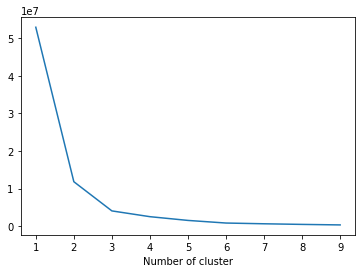

In [310]:
from sklearn.cluster import KMeans
# inertia - Sum of squared distances of samples to their closest cluster center.
sse={}
tx_recency = tx_cust[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [311]:
n_clusters=4

In [312]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters)
kmeans.fit(tx_cust[['Recency']])
tx_cust['RecencyCluster'] = kmeans.predict(tx_cust[['Recency']])
tx_cust


,CustId,Recency,RecencyCluster
0,cust_id_2558,32,1
1,cust_id_1549,13,1
2,cust_id_3970,1,1
3,cust_id_190,28,1
4,cust_id_4253,54,1
5,cust_id_3856,13,1
6,cust_id_1626,0,1
7,cust_id_3936,20,1
8,cust_id_489,124,1
9,cust_id_3788,97,1


In [313]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_cust = order_cluster('RecencyCluster', 'Recency',tx_cust,False)
tx_cust

,CustId,Recency,RecencyCluster
0,cust_id_2558,32,3
1,cust_id_1549,13,3
2,cust_id_3970,1,3
3,cust_id_190,28,3
4,cust_id_4253,54,3
5,cust_id_3856,13,3
6,cust_id_1626,0,3
7,cust_id_3936,20,3
8,cust_id_489,124,3
9,cust_id_3788,97,3


In [314]:
#tx_cust.groupby('RecencyCluster').describe().reset_index()
tx_cust.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,41.0,1621.317073,169.860154,1362.0,1455.00,1623.0,1783.00,1917.0
1,30.0,1030.500000,135.401256,810.0,941.00,1012.0,1142.25,1301.0
2,24.0,548.333333,156.541331,322.0,438.25,510.0,689.50,770.0
3,38.0,74.052632,85.904393,0.0,13.25,38.5,103.00,298.0


In [315]:
# Frequency clustering

#get order counts for each user and create a dataframe with it
tx_frequency = sales.groupby('CustId').Date.count().reset_index()
tx_frequency.columns = ['CustId','Frequency']

#add this data to our main dataframe
tx_cust = pd.merge(tx_cust, tx_frequency, on='CustId')
tx_cust

,CustId,Recency,RecencyCluster,Frequency
0,cust_id_2558,32,3,1977
1,cust_id_1549,13,3,12047
2,cust_id_3970,1,3,16379
3,cust_id_190,28,3,2323
4,cust_id_4253,54,3,528
5,cust_id_3856,13,3,1285
6,cust_id_1626,0,3,12102
7,cust_id_3936,20,3,5131
8,cust_id_489,124,3,2
9,cust_id_3788,97,3,82


In [316]:
#k-means
kmeans = KMeans(n_clusters)
kmeans.fit(tx_cust[['Frequency']])
tx_cust['FrequencyCluster'] = kmeans.predict(tx_cust[['Frequency']])

#order the frequency cluster
tx_cust = order_cluster('FrequencyCluster', 'Frequency',tx_cust,True)

#see details of each cluster
tx_cust.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,111.0,121.009009,214.973550,1.0,4.00,20.0,125.50,1026.0
1,12.0,2115.250000,765.777338,1274.0,1421.25,2021.5,2947.00,3283.0
2,6.0,6052.833333,1106.596117,4718.0,5279.00,6062.5,6517.50,7787.0
3,4.0,12612.000000,2709.026763,9920.0,11515.25,12074.5,13171.25,16379.0


In [317]:
# Revenue Clustering

#calculate revenue for each customer
tx_revenue = sales.groupby('CustId').Revenue.sum().reset_index()

#merge it with our main dataframe
tx_cust = pd.merge(tx_cust, tx_revenue, on='CustId')
tx_cust

,CustId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,cust_id_2558,32,3,1977,1,1.224682e+06
1,cust_id_190,28,3,2323,1,2.260908e+06
2,cust_id_3856,13,3,1285,1,6.237918e+05
3,cust_id_3106,11,3,1274,1,1.069855e+06
4,cust_id_3857,57,3,2971,1,6.820816e+06
5,cust_id_4094,53,3,2939,1,4.849284e+06
6,cust_id_1556,112,3,3283,1,1.240675e+07
7,cust_id_3001,56,3,1332,1,1.354433e+06
8,cust_id_1987,14,3,2066,1,3.381981e+06
9,cust_id_2483,259,3,1451,1,1.326602e+06


In [318]:
#apply clustering
kmeans = KMeans(n_clusters)
kmeans.fit(tx_cust[['Revenue']])
tx_cust['RevenueCluster'] = kmeans.predict(tx_cust[['Revenue']])


#order the cluster numbers
tx_cust = order_cluster('RevenueCluster', 'Revenue',tx_cust,True)
tx_cust
#show details of the dataframe
tx_cust.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,118.0,2.375401e+05,4.672495e+05,5.333320e+01,4.824988e+03,2.929526e+04,1.760842e+05,2.492823e+06
1,9.0,4.903115e+06,1.344896e+06,2.947694e+06,4.039034e+06,4.849284e+06,6.036020e+06,6.820816e+06
2,4.0,1.017428e+07,1.732304e+06,8.411920e+06,9.082378e+06,9.939232e+06,1.103114e+07,1.240675e+07
3,2.0,1.798534e+07,3.559923e+06,1.546809e+07,1.672671e+07,1.798534e+07,1.924396e+07,2.050258e+07


In [319]:
tx_cust

,CustId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,cust_id_2558,32,3,1977,1,1.224682e+06,0
1,cust_id_190,28,3,2323,1,2.260908e+06,0
2,cust_id_3856,13,3,1285,1,6.237918e+05,0
3,cust_id_3106,11,3,1274,1,1.069855e+06,0
4,cust_id_3001,56,3,1332,1,1.354433e+06,0
5,cust_id_2483,259,3,1451,1,1.326602e+06,0
6,cust_id_925,957,1,1490,1,9.648429e+05,0
7,cust_id_2774,462,2,2992,1,8.987671e+05,0
8,cust_id_4253,54,3,528,0,2.492823e+06,0
9,cust_id_489,124,3,2,0,5.699986e+03,0


In [320]:
#calculate overall score and use mean() to see details

tx_cust['OverallScore'] = tx_cust['RecencyCluster'] + tx_cust['FrequencyCluster'] + tx_cust['RevenueCluster']
tx_cust.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()


,Recency,Frequency,Revenue
OverallScore,,,
0,1621.317073,37.146341,4.301921e+04
1,1027.000000,115.357143,1.361761e+05
2,570.217391,157.826087,1.912781e+05
3,179.285714,453.857143,8.859647e+05
4,66.500000,1607.000000,1.310045e+06
5,166.000000,3594.500000,4.772779e+06
6,27.600000,5328.400000,6.899194e+06
7,19.000000,8238.000000,6.126779e+06
8,13.000000,12047.000000,1.057260e+07


In [321]:
tx_cust['Segment'] = 'Low-Value'
tx_cust.loc[tx_cust['OverallScore']>2,'Segment'] = 'Mid-Value' 
tx_cust.loc[tx_cust['OverallScore']>4,'Segment'] = 'High-Value' 

In [322]:
tx_cust

,CustId,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,cust_id_2558,32,3,1977,1,1.224682e+06,0,4,Mid-Value
1,cust_id_190,28,3,2323,1,2.260908e+06,0,4,Mid-Value
2,cust_id_3856,13,3,1285,1,6.237918e+05,0,4,Mid-Value
3,cust_id_3106,11,3,1274,1,1.069855e+06,0,4,Mid-Value
4,cust_id_3001,56,3,1332,1,1.354433e+06,0,4,Mid-Value
5,cust_id_2483,259,3,1451,1,1.326602e+06,0,4,Mid-Value
6,cust_id_925,957,1,1490,1,9.648429e+05,0,2,Low-Value
7,cust_id_2774,462,2,2992,1,8.987671e+05,0,3,Mid-Value
8,cust_id_4253,54,3,528,0,2.492823e+06,0,3,Mid-Value
9,cust_id_489,124,3,2,0,5.699986e+03,0,3,Mid-Value


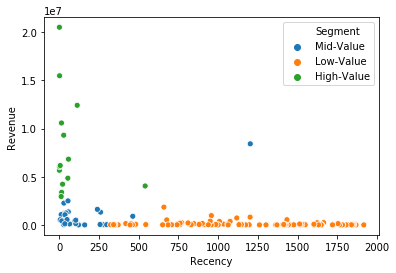

In [334]:
sns.scatterplot(x="Recency", y="Revenue", data=tx_cust, hue="Segment")

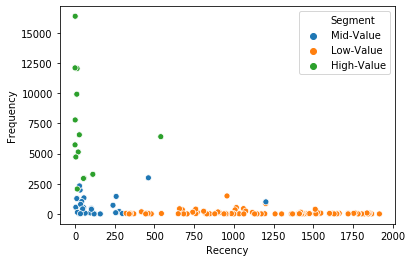

In [335]:
sns.scatterplot(x="Recency", y="Frequency", data=tx_cust, hue="Segment")

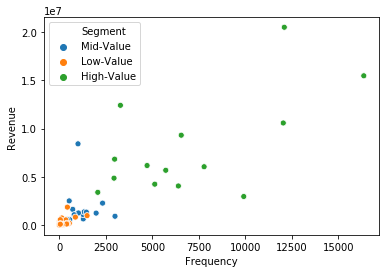

In [336]:
sns.scatterplot(x="Frequency", y="Revenue", data=tx_cust, hue="Segment")